In [866]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA

In [867]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [868]:
import sys
sys.path.append("../scripts")

from State import *
from Functions import *
from Gates import *

In [869]:
# Возвращает вектора состояний подсистем
def split_system_rho(rho, na, nb):

    d = int(2**na)
    k = int(2**nb)

    rho = np.reshape(rho, (d,k,d,k))
    rho_A = np.trace(rho, axis1=1, axis2=3)
    rho_B = np.trace(rho, axis1=0, axis2=2)
    
    return rho_A, rho_B

# Возвращает вектора состояний подсистем
def split_system(coefs, na, nb):

    d = int(2**na)
    k = int(2**nb)

    rho = np.outer(coefs, np.conjugate(coefs))
    rho = np.reshape(rho, (d,k,d,k))
    rho_A = np.trace(rho, axis1=1, axis2=3)
    rho_B = np.trace(rho, axis1=0, axis2=2)
    
    s, v = LA.eig(rho_A)
    # B_vec = v[:, 0]
    A_coefs = np.dot(v, s)
    
    s, v = LA.eig(rho_B)
    # B_vec = v[:, 0]
    B_coefs = np.dot(v, s)
    return A_coefs, B_coefs

# Возвращает Fidelity
def Fidelity(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2

def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

In [870]:
# Заданное состояние
coefs0 = 1/np.sqrt(3)*(np.array([1,0]) + 1j*np.sqrt(2)*np.array([0,1]))
print(coefs0, coefs0@coefs0.conj())

[0.57735027+0.j         0.        +0.81649658j] (1.0000000000000002+0j)


$\qquad$ Зададим схемму кодирующую состояние для коррекции ошибок:

<img src="Images/code_correction.png">

In [871]:
def code_correction(coefs):
    coefs = apply_U(CX(), coefs, [0,1])
    coefs = apply_U(CX(), coefs, [0,2])
    
    coefs = apply_U(H(), coefs, [0])
    coefs = apply_U(H(), coefs, [1])
    coefs = apply_U(H(), coefs, [2])
    return coefs

$\qquad$ Зададим схемму выявляющую синдром ошибок:

<img src="Images/syndrom.png">

In [872]:
# Функция выявляет синдром ошибки

def apply_correction(coefs_list):
    
    # цикл внутри нужен для применения корневого подхода
    # вместо вектора коэффициенов состояния имеем
    # на входе лист векторов, по которому пробегаемся в цикле
    
    coefs_list_new = []
    for coefs1 in coefs_list:
        coefs = copy.deepcopy(coefs1)
        coefs = apply_U(H(), coefs, [0])
        coefs = apply_U(H(), coefs, [1])
        coefs = apply_U(H(), coefs, [2])

        coefs = apply_U(CX(), coefs, [0,3])
        coefs = apply_U(CX(), coefs, [1,3])
        coefs = apply_U(CX(), coefs, [0,4])
        coefs = apply_U(CX(), coefs, [2,4])

        coefs = apply_U(H(), coefs, [0])
        coefs = apply_U(H(), coefs, [1])
        coefs = apply_U(H(), coefs, [2])

        # Блок исправления ошибок с помощью CCZ гейтов
        # Добавляется фаза на один из 3 кубитов основного 
        # регистра в зависимости от значений вспомогательных
        
        coefs = apply_U(H(), coefs, [0])
#         state.apply_long_Toffoli([4,3,0])
        coefs = apply_U(TOFFOLI(), coefs, [4,3,0])
        coefs = apply_U(H(), coefs, [0])

        coefs = apply_U(X(), coefs, [4])
        coefs = apply_U(H(), coefs, [1])
#         state.apply_long_Toffoli([4,3,1])
        coefs = apply_U(TOFFOLI(),  coefs, [4,3,1])
        coefs = apply_U(H(), coefs, [1])
        coefs = apply_U(X(), coefs, [4])

        coefs = apply_U(X(), coefs, [3])
        coefs = apply_U(H(), coefs, [2])
#         state.apply_long_Toffoli([4,3,2])
        coefs = apply_U(TOFFOLI(),  coefs, [4,3,2])
        coefs = apply_U(H(), coefs, [2])
        coefs = apply_U(X(), coefs, [3])
        coefs_list_new.append(coefs)

    return coefs_list_new

In [873]:
# ССZ из TOFFOLI
H(0,3)@TOFFOLI()@H(0,3)

array([[ 1.00000000e+00+0.j, -2.23711432e-17+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [-2.23711432e-17+0.j,  1.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  1.00000000e+00+0.j,
        -2.23711432e-17+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -2.23711432e-17+0.j,
         1.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  1.00000000e+00+0.j, -2.23711432e-17+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.000

In [874]:
# Создадим расширенное состояние:

# Заданное состояние
coefs0 = 1/np.sqrt(3)*(np.array([1,0]) + 1j*np.sqrt(2)*np.array([0,1]))

# 4 кубита в 0-ом состоянии
coefs1 = np.zeros(2**4) + 1j*np.zeros(2**4)
coefs1[0] = 1

# Итоговое состояние
coefs = np.kron(coefs0, coefs1)
cc = copy.deepcopy(coefs)
print('Вектор начального состояния:')
print(list(coefs))

Вектор начального состояния:
[(0.5773502691896258+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0.8164965809277261j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]


In [875]:
coefs = copy.deepcopy(cc)

# Запустим код коррекции в отсутствии ошибок и найдём полученное состояние:
coefs = code_correction(coefs)
coefs_A_init, _ = split_system(coefs, 3, 2)
coefs_list = apply_correction([coefs])
coefs_A_clear, _ = split_system(coefs_list, 3, 2)

# Проверим код коррекции ошибок применяя Z-гейт к произвольному из закодированных кубитов:

coefs = copy.deepcopy(cc) # возвращаем коэффициенты в начальное состояние

coefs =  code_correction(coefs)
coefs = apply_U(Z(), coefs, [0])
coefs_list = apply_correction([coefs])
coefs_A_err0, _ = split_system(coefs_list, 3, 2)

coefs = copy.deepcopy(cc)

coefs = code_correction(coefs)
coefs = apply_U(Z(), coefs, [1])
coefs_list = apply_correction([coefs])
coefs_A_err1, _ = split_system(coefs_list, 3, 2)

coefs = copy.deepcopy(cc)

coefs = code_correction(coefs)
coefs = apply_U(Z(), coefs, [2])
coefs_list = apply_correction([coefs])
coefs_A_err2, _ = split_system(coefs_list, 3, 2)

print('Fidelity между начальным закодированным состоянием и конечным:')
print(Fidelity_pure(coefs_A_clear, coefs_A_init))

print('Fidelity при ошибке на 0-ом кубите:')
print(Fidelity_pure(coefs_A_clear, coefs_A_err0))

print('Fidelity при ошибке на 1-ом кубите:')
print(Fidelity_pure(coefs_A_clear, coefs_A_err1))

print('Fidelity при ошибке на 2-ом кубите:')
print(Fidelity_pure(coefs_A_clear, coefs_A_err2))


Fidelity между начальным закодированным состоянием и конечным:
0.9999999999999942
Fidelity при ошибке на 0-ом кубите:
0.9999999999999898
Fidelity при ошибке на 1-ом кубите:
0.9999999999999898
Fidelity при ошибке на 2-ом кубите:
0.9999999999999898


Видно, что корректировка ошибок выполняется и более того не изменяет начального состояния

In [876]:
# Возвращает расширенные до размерности 5 кубитов
# операторы Краусса, действуюшие на заданный кубит

def kraus_list(p, wire, n):
    E0 = expand(np.sqrt(1-p)*I(), wire, n)
    E1 = expand(np.sqrt(0.9*p)*Z(), wire, n)
    E2 = expand(np.sqrt(0.1*p)*T(), wire, n)
    return [E0,E1,E2]

# применяет приближённый оператор Краусса, пользуясь корневым подходом
def apply_kraus(coefs_list, p, wire, rank = 5):
    coefs_list_new = []
    k_list = kraus_list(p, wire, int(np.log2(len(coefs_list[0]))))
    for kraus in k_list:
        for coefs in coefs_list:
            coefs_list_new.append(np.dot(kraus, coefs))

    return coefs_list_new

In [877]:
print(len(coefs))
print(len(apply_kraus(np.array([coefs]), 0.8, 1, rank = 2)))

32
3


In [878]:
# Функция чтобы выводить точность в процессе
# реализации преобразований квантовой схемы
def show(coefs_list, rho1):
    coefs_list = np.array(coefs_list)
    rho = np.dot(np.conjugate(coefs_list).T, coefs_list)
    rho_A, _ = split_system_rho(rho, 3, 2)
    print(Fidelity(rho_A, rho1))

In [879]:
# Функция прменяет канал ошибки 
# 

def apply_error(coefs, p, err_correction = False):
    
    if err_correction == False:
        # Найдём выходное сстояние без влияния ошибок состояние
        rho = np.outer(np.conjugate(coefs), coefs)
        coefs_list_new = apply_kraus(np.array([coefs]), p, 0)
        rho_new = np.dot(np.conjugate(coefs_list_new).T, coefs_list_new)
        F = Fidelity(rho_new, rho)
        
    elif err_correction == True:
        
        coefs1 = np.zeros(2**4) + 1j*np.zeros(2**4)
        coefs1[0] = 1

        # Найдём итоговое состояние без воздействия ошибки
        coefs = np.kron(coefs, coefs1)
        cc = copy.deepcopy(coefs)
        
        
        coefs = code_correction(coefs)
        
        coefs_list = np.array([coefs])
        
        coefs_list = apply_correction(coefs_list)

        coefs_list = np.array(coefs_list)
        rho = np.dot(np.conjugate(coefs_list).T, coefs_list)
        rho_A, _ = split_system_rho(rho, 3, 2)
       
        
        
        # Найдём итоговое состояние с воздействием ошибки
        coefs = copy.deepcopy(cc)
        coefs = code_correction(coefs)

        coefs_list = apply_kraus(np.array([coefs]), p, wire = 0)
        coefs_list = apply_kraus(coefs_list, p, wire = 1)
        coefs_list = apply_kraus(coefs_list, p, wire = 2)
        
        coefs_list = np.array(coefs_list)
        
        coefs_list = apply_correction(coefs_list)

        coefs_list = np.array(coefs_list)
        rho_new = np.dot(np.conjugate(coefs_list).T, coefs_list)
        rho_A_new, _ = split_system_rho(rho_new, 3, 2)
        

        
        
        F = Fidelity(rho_A, rho_A_new)
        
    return F
        


In [880]:
coefs0 = 1/np.sqrt(3)*(np.array([1,0]) + 1j*np.sqrt(2)*np.array([0,1]))
p = 0.5
f1 = apply_error(coefs0, p = p, err_correction = True)
f2 = apply_error(coefs0, p = p, err_correction = False)
f1, f2

(0.8623889297872166, 0.5944444541732058)

In [881]:
coefs0 = 1/np.sqrt(3)*(np.array([1,0]) + 1j*np.sqrt(2)*np.array([0,1]))

p_list = np.linspace(0,0.7, 100)
F_list = []
F_corr_list = []

for p in p_list:
    F = apply_error(coefs0, p = p, err_correction = False)
#     print(F)
    F_list.append(F)
    
    F_corr = apply_error(coefs0, p = p, err_correction = True)
    F_corr_list.append(F_corr)
    
    

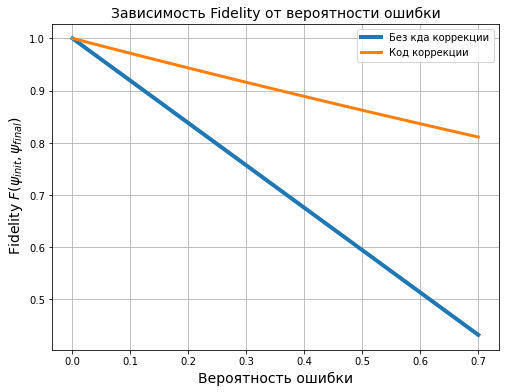

In [882]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_title(f'Зависимость Fidelity от вероятности ошибки', fontsize = 14)
ax.plot(p_list, F_list, label = r'Без кда коррекции', linewidth = 4)
ax.plot(p_list, F_corr_list, label = r'Код коррекции', linewidth = 3)

plt.grid()
plt.xlabel(r'Вероятность ошибки', fontsize = 14)
plt.ylabel(r' Fidelity $F(\psi_{init}, \psi_{final} )$', fontsize = 14)
plt.legend()
plt.show()
